# Noise Example Notebook
## "Explain Me This: Salience-Based Explainability for Synthetic Face Detection Models"
### by Colton R. Crum, 1/31/23

In [30]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
import scipy.ndimage
from copy import deepcopy
import tensorflow as tf
import pandas as pd
import json
import glob
from sklearn.utils import resample
from scipy import optimize
from scipy.optimize import brenth
import sys
import argparse
from scipy.ndimage.filters import gaussian_filter
import skimage.io
import skimage.filters
from random import randrange
from PIL import Image
import tensorflow as tf
from absl import app, flags
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D
from torchvision.io import read_image
import matplotlib.image as mpimg
import torch
import torchvision.models as models
import torch.nn as nn
import torchvision.transforms as transforms
import csv
from tqdm import tqdm
from mpl_toolkits.axes_grid1 import ImageGrid
#sys.path.append("../")
#from xception.network.models import model_selection

## Necessary Arguments

In [57]:
parser = argparse.ArgumentParser()
# dummy argument to work in Jupyter Notebook instead of command line
parser.add_argument('-f')
parser.add_argument('-mp', '--modelPath', default="../../Models/weights/Densenet/densenet_cyborg_1/Logs/final_model.pth", type=str)
parser.add_argument('-n', '--network', default="densenet", type=str)
parser.add_argument('-d', '--dataset', default="../../Data/images/ffhq_aligned/00001.png", type=str)
parser.add_argument('-t', '--type', default="s&p", type=str)
parser.add_argument('-a', '--amount', default=0.05, type=float)

args = vars(parser.parse_args())

In [58]:
device = torch.device('cpu')

## Loading in the model

In [59]:
# Load weights of single binary DesNet121 model
weights = torch.load(args["modelPath"], map_location=device)

if args["network"] == "resnet":
    im_size = 224
    model = models.resnet50(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 2)
elif args["network"] == "inception":
    im_size = 299
    model = models.inception_v3(pretrained=True,aux_logits=False)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 2)
elif args["network"] == "xception":
    im_size = 299
    model, *_ = model_selection(modelname='xception', num_out_classes=2)
else: # else DenseNet
    im_size = 224
    model = models.densenet121(pretrained=True)
    num_ftrs = model.classifier.in_features
    model.classifier = nn.Linear(num_ftrs, 2)

model.load_state_dict(weights['state_dict'])
model = model.to(device)
model.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [61]:
sigmoid = nn.Sigmoid()

## Preprocessing

In [60]:
if args["network"] == "xception":
    # Transformation specified for the pre-processing
    transform = transforms.Compose([
                transforms.Resize([im_size, im_size]),
                transforms.ToTensor(),
                transforms.Normalize([0.5]*3, [0.5]*3)
            ])
else:
    # Transformation specified for the pre-processing
    transform = transforms.Compose([
                transforms.Resize([im_size, im_size]),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])

## Getting Original Prediction

In [79]:
predictions = []

# Read the Image
image = skimage.io.imread(args['dataset'])
image = Image.fromarray(image)

# Model Preprocessing
tranformImage = transform(image)
tranformImage = tranformImage[0:3,:,:].unsqueeze(0)
tranformImage = tranformImage.to(device)

# Get Prediction From Model
with torch.no_grad():
    output = model(tranformImage)

PAScore = round(sigmoid(output).detach().cpu().numpy()[:, 1][0], 3)
predictions.append(PAScore)
print(PAScore)

0.781


## Getting Prediction of Noisy Image

In [80]:
# Read the Image
image = skimage.io.imread(args['dataset'])
# Generating Random Noise
salt_pepper = skimage.util.random_noise(image, mode=args['type'], amount=args['amount'])
salt_pepper = np.array((salt_pepper * 255).astype(np.uint8))
salt_pepper = Image.fromarray(salt_pepper)
# Model Preprocessing
tranformImage = transform(salt_pepper)
tranformImage = tranformImage[0:3,:,:].unsqueeze(0)
tranformImage = tranformImage.to(device)

# Get Prediction From Model
with torch.no_grad():
    output = model(tranformImage)
    
PAScore = round(sigmoid(output).detach().cpu().numpy()[:, 1][0], 3)
predictions.append(PAScore)
print(PAScore)

0.017


## Display Both Images

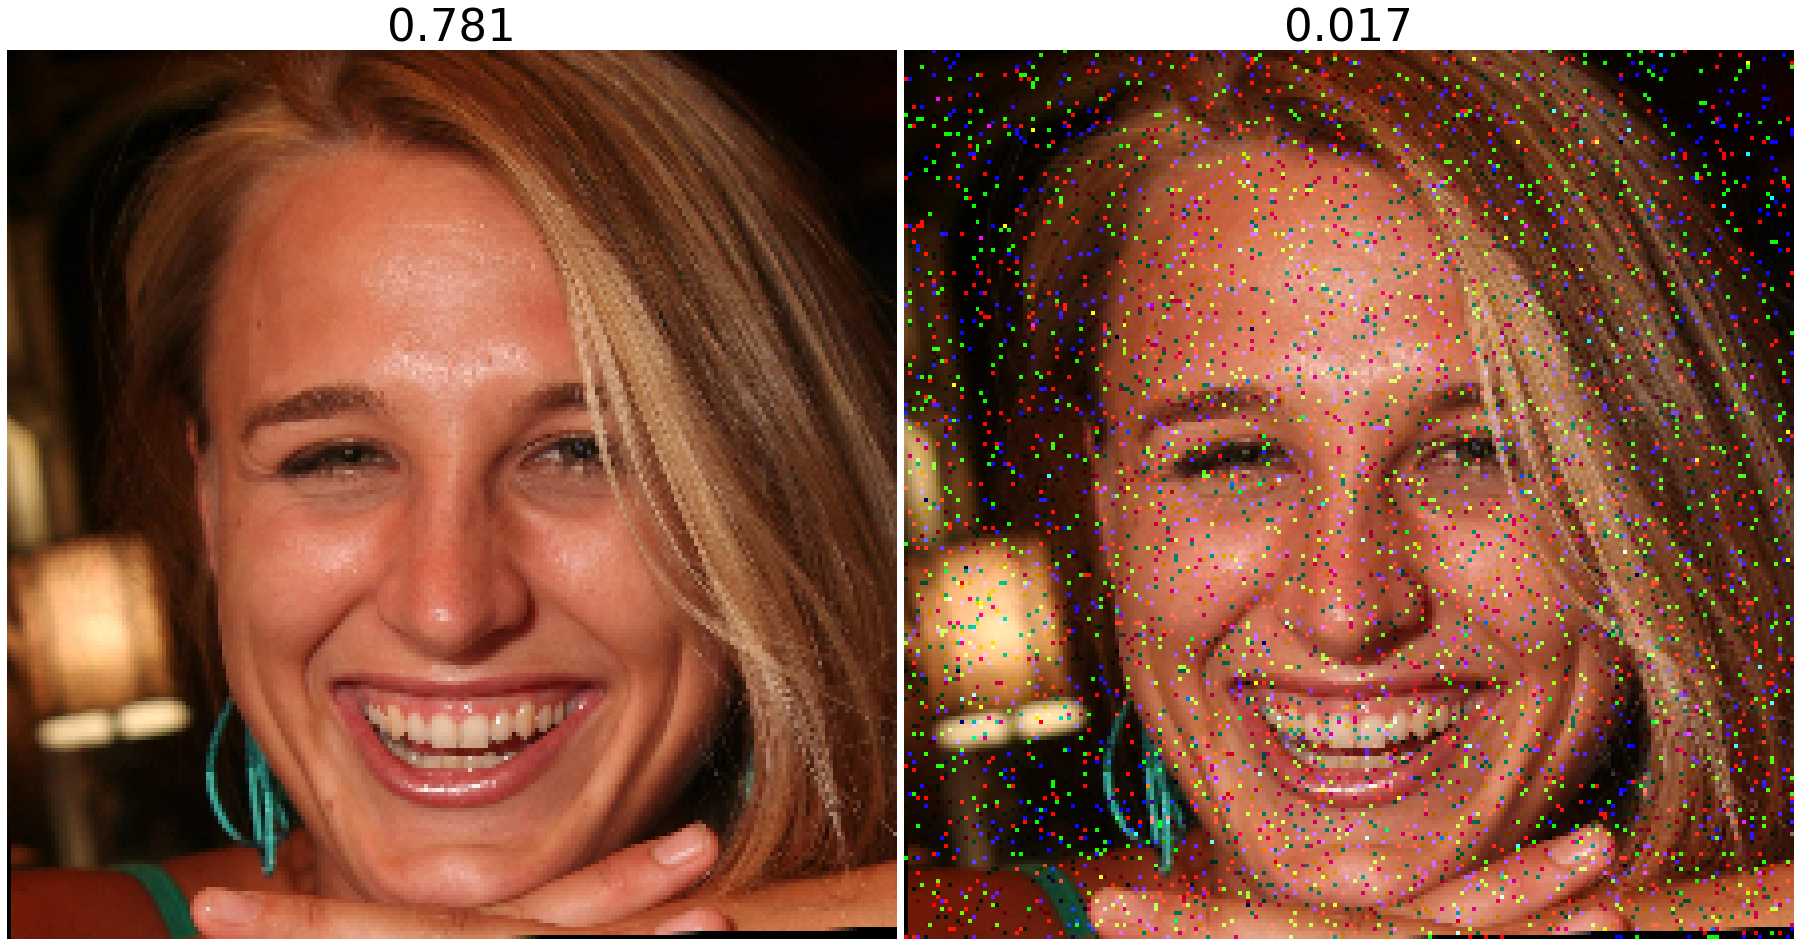

In [83]:
fig = plt.figure(figsize=(10., 8.), facecolor='white')
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 2),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
for index, (ax, im) in enumerate(zip(grid, [image, salt_pepper])):
    # Iterating over the grid returns the Axes.
    ax.axis('off')
    ax.grid(b=None)
    ax.imshow(im)
    ax.set_title(predictions[index], fontsize=45)
fig.set_size_inches(32, 18)
#plt.savefig("noise-densenet-example.png", format='png', bbox_inches='tight', dpi = 500)
plt.show()